Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

problem1-reg_data.csv – данные о времени регистрации

problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

### Изучим исходные данные

In [1]:
import pandas as pd

In [2]:
regs = pd.read_csv('problem1-reg_data.csv', sep = ';')
visits = pd.read_csv('problem1-auth_data.csv', sep = ';')

In [3]:
regs.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
regs.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
visits.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
visits.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
visits.dtypes

auth_ts    int64
uid        int64
dtype: object

### Функция для расчета retention игроков

In [8]:
def retention_by_cohort(path_reg, path_auth):
    
    import pandas as pd
    import datetime 
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(20,16))
    
    regs = pd.read_csv(path_reg, sep = ';')
    visits = pd.read_csv(path_auth, sep = ';')
    
    # приводим даты в удобный формат
    regs['reg_ts'] = pd.to_datetime(regs.reg_ts, unit='s').dt.date
    visits['auth_ts'] = pd.to_datetime(visits.auth_ts, unit='s').dt.date
    
    # для проверки функции ограничимся одним месяцем
    reg_test = regs.query('reg_ts >= datetime.date(2020,1,1)')
    visits_test = visits.query('auth_ts <= datetime.date(2020,1,31)')

    # объединим все данные в один датафрейм
    regs_and_auths = pd.merge(visits_test, reg_test, on='uid')
    
    # вычисляем разницу дат
    regs_and_auths['visit_days'] = (regs_and_auths['auth_ts'] - regs_and_auths['reg_ts']).dt.days + 1

    # формируем когорты пользователей
    cohorts_df = regs_and_auths.groupby(['reg_ts', 'visit_days'])['uid'].nunique().reset_index() 
    cohorts = cohorts_df.pivot(index='reg_ts', columns='visit_days', values='uid')
    base = cohorts[1] 
    retention = cohorts.divide(base, axis=0).round(3)
    
    plt.title('User retention by cohort')
    ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.12,
                     cmap= 'coolwarm', linewidths=0.5, linecolor='black')
    ax.set_yticklabels(retention.index)
    fig = ax.get_figure()
    
    plt.show()
    
    return retention

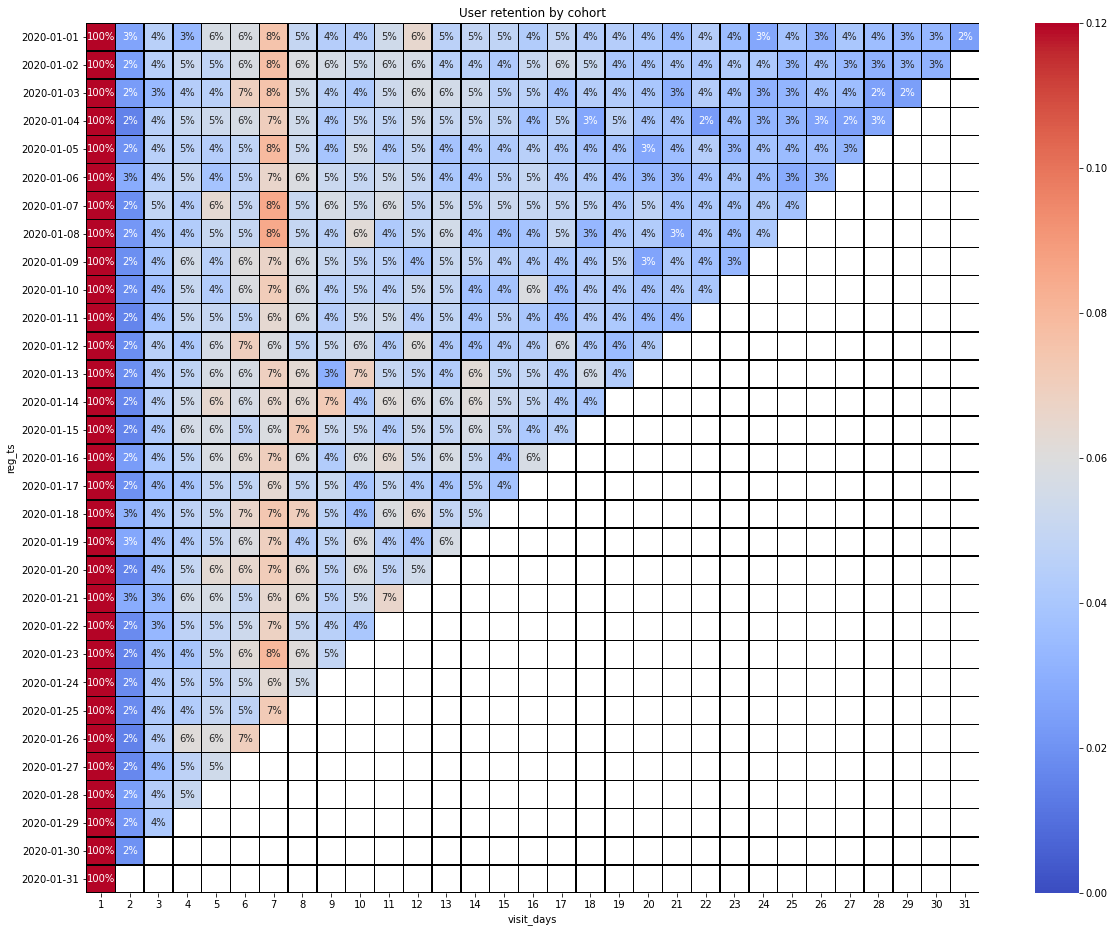

In [9]:
path_reg = 'problem1-reg_data.csv'
path_auth = 'problem1-auth_data.csv'
retention_data = retention_by_cohort(path_reg, path_auth)

## Задание №2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [10]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

#import matplotlib.ticker as mtick
from statsmodels.stats.proportion import proportions_ztest

In [11]:
df = pd.read_csv('problem2.csv', sep=';')

In [12]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [14]:
# подготовим данные и соберем полученную информацию в таблицу для наглядности

group_a = df.query('testgroup == "a"')
group_b = df.query('testgroup == "b"')

# количество пользователей в группах
users_quantity_a = group_a.shape[0]
users_quantity_b = group_b.shape[0]

# выручка
total_revenue_a =  group_a.revenue.sum()
total_revenue_b =  group_b.revenue.sum()

# количество покупок в группах
checks_a_quantity = group_a.query('revenue > 0').shape[0]
checks_b_quantity = group_b.query('revenue > 0').shape[0]

# количество клиентов в группах
clients_a_quantity = group_a.query('revenue > 0').user_id.nunique()
clients_b_quantity = group_b.query('revenue > 0').user_id.nunique()
    
# конверсия в покупателя
cr_a = round(clients_a_quantity / group_a.shape[0] * 100, 2)
cr_b = round(clients_b_quantity / group_a.shape[0] * 100 ,2)
         
# средний чек
avg_check_a = round(group_a.query('revenue > 0').revenue.mean(), 2)
avg_check_b = round(group_b.query('revenue > 0').revenue.mean(), 2)
   
# ARPU
arpu_a = round(group_a.revenue.sum() / group_a.shape[0], 2)
arpu_b = round(group_b.revenue.sum() / group_b.shape[0], 2)

# ARPPU
arppu_a = round(group_a.revenue.sum() / clients_a_quantity, 2)
arppu_b = round(group_b.revenue.sum() / clients_b_quantity, 2)
    
# коэффициент повторных покупок
rep_purch_a = round(checks_a_quantity / clients_a_quantity, 2)
rep_purch_b = round(checks_b_quantity / clients_b_quantity, 2)

df = pd.DataFrame({'group': ["control", "test"],
                   'users': [users_quantity_a, users_quantity_b],
                   'clients': [clients_a_quantity, clients_b_quantity],
                   'total_revenue': [total_revenue_a, total_revenue_b],
                   'CR': [cr_a, cr_b],
                   'avg_check': [avg_check_a, avg_check_b],
                   'arpu': [arpu_a, arpu_b],
                   'arppu': [arppu_a, arppu_b],
                   'rep_purch': [rep_purch_a, rep_purch_b]}
                 )

df

,group,users,clients,total_revenue,CR,avg_check,arpu,arppu,rep_purch
0,control,202103,1928,5136189,0.95,2664.00,25.41,2664.00,1.0
1,test,202667,1805,5421603,0.89,3003.66,26.75,3003.66,1.0


Проверим распределения величин "revenue" в контрольной и тестовой группах.

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)


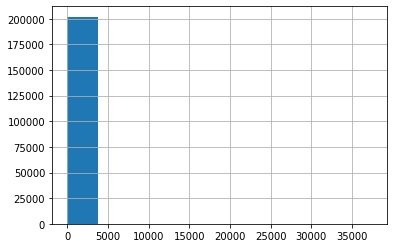

In [15]:
group_a.revenue.hist()
print(stats.shapiro(group_a.revenue.sample(1000, random_state=17)))

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)


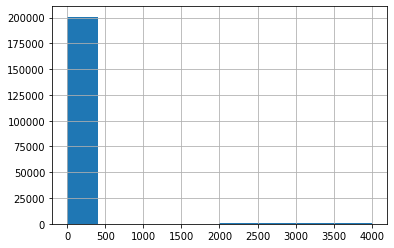

In [16]:
group_b.revenue.hist()
print(stats.shapiro(group_b.revenue.sample(1000, random_state=17)))

Тест Шапиро-Уилка подтверждает, что распределения "revenue" контрольной и тестовых групп не являются нормальными. 
Следовательно, для сравнения групп будем ипользовать бутстрэп. Но сначала рассмотрим их более детально.

array([  311.  , 37299.65, 37340.73])

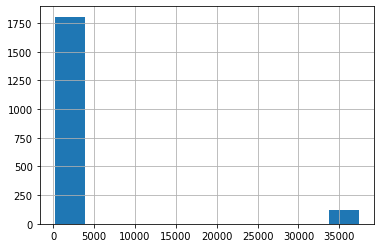

In [17]:
group_a.query('revenue != 0').revenue.hist()
np.percentile(group_a.query('revenue != 0').revenue, [50, 95, 99])

array([305., 391., 398.])

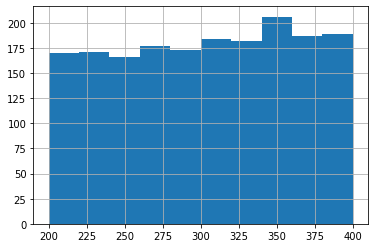

In [18]:
group_a.query('revenue != 0 and revenue < 37000').revenue.hist()
np.percentile(group_a.query('revenue != 0 and revenue < 37000').revenue, [50, 95, 99])

In [19]:
group_a.query('revenue > 37000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


array([37311.  , 37368.7 , 37404.14])

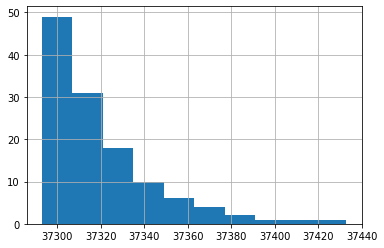

In [20]:
group_a.query('revenue > 37000').revenue.hist()
np.percentile(group_a.query('revenue > 37000').revenue, [50, 95, 99])

In [21]:
# print(round(group_a.query('revenue > 37000').shape[0] / group_a.shape[0] * 100, 2), 
#       round(group_a.query('revenue != 0 and revenue > 37000').shape[0] / clients_a_quantity, 2))

In [22]:
round(group_a.query('revenue > 37000').revenue.sum() / total_revenue_a * 100, 2)

89.37

### В контрольной группе 123 клиента с наибольшими чеками (от 37324) обеспечивают 89,37% процентов выручки.
Остальные 1805 клиентов генерируют оставшиеся 10.63%, величины их транзакции распределены между значениями 200 и 400.
Таким образом контрольная группа делится на 2 неравные подгруппы. 

array([3022.  , 3891.8 , 3981.92])

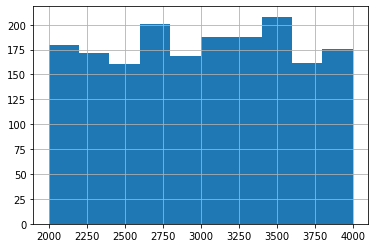

In [23]:
group_b.query('revenue != 0').revenue.hist()
np.percentile(group_b.query('revenue != 0').revenue, [50, 95, 99])

### В тестовой группе ситуация обстоит совершенно по-другому: все транзакции клиентов распределены между 2000 и 4000.

Воспользуемся bootsrap'ом для сравнения групп.

In [24]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Тест ARPU:

  0%|          | 0/1000 [00:00<?, ?it/s]

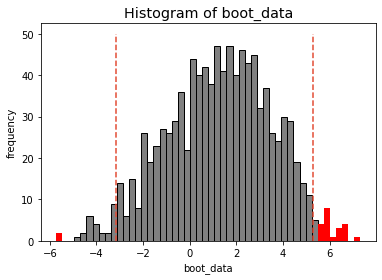

0.5706419621941013


In [25]:
booted_mean_data = get_bootstrap(group_b.revenue, group_a.revenue)
print(booted_mean_data["p_value"])

Тест ARPPU:

  0%|          | 0/1000 [00:00<?, ?it/s]

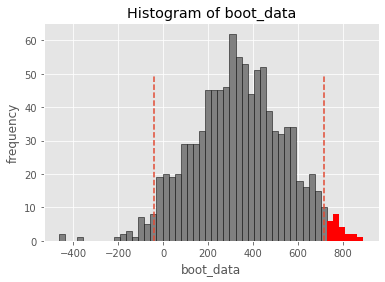

0.09778100745711263


In [26]:
booted_mean_data = get_bootstrap(group_b.query('revenue > 0').revenue,
                                 group_a.query('revenue > 0').revenue)
print(booted_mean_data["p_value"])

Можно сделать вывод, что между средними значениями ARPU и ARPPU тестовой и контрольной групп нет стат.значимой разницы: p-value в обоих случаях больше 0.05

Тест конверсии:

In [27]:
# для этой цели воспользуемся proportions_ztest (!может меня кто-то поправит, я не уверен, что он в полной мере подходит!)
count = np.array([group_a.query('revenue > 0').user_id.nunique(), group_b.query('revenue > 0').user_id.nunique()])
nobs = np.array([group_a.user_id.nunique(), group_b.user_id.nunique()])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = 2.108028495889841 
 p-value = 0.035028524642854865


Значения коэффициентов конверсии в плательщика в тестовой и контрольной группах стат.значимо различаются.

Выводы: В процессе

 
## Задание №3 
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время.

С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

ОТВЕТ: в процессе